<a href="https://colab.research.google.com/github/claudiosegala/Monografia/blob/master/code/tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

+ Discover why the result are being inconsistent
+ Discover if there are negative predictions and NaNs
+ Discover why some results came negative (that does not make sense, but the evaluation with log is getting errors)
+ Normalize RMSE

+ Implement SVM/SVC [[1]](https://gist.github.com/ledmaster/031e531ea35494d2357926405532e254#file-multipletimeseriesforecasting-ipynb)
+ Implement Random Forest[[1]](https://pythondata.com/forecasting-with-random-forests/) [[2]](https://stats.stackexchange.com/questions/384924/using-a-random-forest-for-time-series-data)
+ Implement Clipping for the Machine Learning Models [[1]](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/)


## READ

+ [Time Series Forecasting as Supervised Learning](https://machinelearningmastery.com/time-series-forecasting-supervised-learning/)
+ [Why LSTM performs worse in information latching than vanilla recurrent neuron network](https://stats.stackexchange.com/questions/340898/why-lstm-performs-worse-in-information-latching-than-vanilla-recurrent-neuron-ne)

# Install Dependencies

In this phase we have to download all the dependencies that our code will need

In [94]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install keras
!pip install statsmodels

# Define headers

In this phase we have to declare all the libraries that we will use.

In [0]:
import tensorflow as tf # machine learning library
import pandas as pd # data manipulation library
import matplotlib.pyplot as plt # plot library
import numpy as np # math library
import datetime as dt # to discover week day
import time as tm # to convert to seconds
import sklearn as skl # regression templates library
import sklearn.metrics as sklm # metrics
import random as rnd # random
import statistics as st # statistics
import statsmodels as sm # statistical models
import statsmodels.api as sma # statistical models api
import keras # keras

# Plot & Print Functions

In [0]:
def plot_history (history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.figure(figsize=(100, 100))
  plt.show(name + "ind")
  plt.close('all')
  
def print_metrics (Y_hat, Y_test):
  #evs = sklm.explained_variance_score(Y_test, Y_hat)
  mse = sklm.mean_squared_error(Y_test, Y_hat)
  mae = sklm.mean_absolute_error(Y_test, Y_hat)
  #msle = sklm.mean_squared_log_error(Y_test, Y_hat)
  me = sklm.max_error(Y_test, Y_hat)
  
  #print(f"EVS: {evs}")
  print(f"RMSE: {np.sqrt(mse)}")
  print(f"MSE: {mse}")
  print(f"MAE: {mae}")
  #print(f"MSLE: {msle}")
  print(f"Max Error: {me}")

# Statistical Functions

In [0]:
def rmse (actual, expectation):
  mse = sklm.mean_squared_error(actual, expectations)
  
  return np.sqrt(mse)

# Configure Hyperparameters

In [0]:
VALIDATION_SPLIT = 0.25

TRAIN_SPLIT = 0.8

SEEABLE_PAST = 100 # in minutes

PREDICT_IN_FUTURE = 60 # in minutes

FLOW_INTERVAL = 150 # the interval size for each flow

MULTIVARIATE = False # if we are gonna use multiple data or not

# Derivated

N_STEPS = SEEABLE_PAST * 60 // FLOW_INTERVAL # the number of flows to see in the past

N_FUTURE = PREDICT_IN_FUTURE * 60 // FLOW_INTERVAL # how much in the future we want to predict (0 = predict the flow on the next 5 minutes)

N_FEATURES = 9 if MULTIVARIATE else 1

DAY_SIZE = (24 * 3600) // FLOW_INTERVAL  

WEEK_SIZE = 7 * DAY_SIZE

# Mount Drive

Connect to Google Drive of 'alfredcoinworth'

In [99]:
import google as g # To connect with google drive
g.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Retrieval

This phase we have to get the data stored in Google Drive.


In [100]:
col_names = ['Sensor', 'Date', 'Time', 'Lane', 'Speed', 'Max Speed', 'Size']
all_data = pd.read_csv('/content/drive/My Drive/TCC/chunks/all_data_sorted.csv', ';', header=None, names=col_names)
all_data.head()

,Sensor,Date,Time,Lane,Speed,Max Speed,Size
0,RSI128,2016/05/01,00:00:09,1,26.0,60.0,0.0
1,RSI131,2016/05/01,00:00:09,2,20.0,60.0,1.1
2,RSI132,2016/05/01,00:00:09,1,45.0,60.0,0.0
3,RSI131,2016/05/01,00:00:10,1,40.0,60.0,0.5
4,RSI129,2016/05/01,00:00:12,1,35.0,60.0,0.0


# Data Pre-processing



In [101]:
def adjust_data(data):
  # Extract data from just one sensor
  data = data[data['Sensor'] == 'RSI128']
  
  # Remove unnecessary columns
  data = data.drop(columns=['Sensor','Lane','Max Speed','Size'])
   
  # Adjust type
  data['Time'] = data['Time'].apply(lambda x : tm.strptime(x, '%H:%M:%S'))
  data['Time'] = data['Time'].apply(lambda x : dt.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds())
  data['Time'] = data['Time'].apply(lambda x : int(x))
  data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
  data['Speed'].apply(lambda x : float(x))
  
  # Create week day from date
  data['WeekDay'] = data['Date'].apply(lambda x : x.weekday())
  
  return data


data = adjust_data(all_data)
data.head()

,Date,Time,Speed,WeekDay
0,2016-05-01,9,26.0,6
7,2016-05-01,18,32.0,6
39,2016-05-01,104,16.0,6
108,2016-05-01,206,22.0,6
160,2016-05-01,305,25.0,6


# Data Analysis

In [102]:
print(f"This data is from <{data['Date'].min()}> to <{data['Date'].max()}>\n")

print(f"It contains {len(data['Date'])} entries\n")

for col, cont in data.iteritems():
    print(f"Column {col} has {cont.isnull().sum()} null elements and {cont.isna().sum()} nan elements")
    
print()

data.describe()

This data is from <2016-05-01 00:00:00> to <2016-07-31 00:00:00>

It contains 536879 entries

Column Date has 0 null elements and 0 nan elements
Column Time has 0 null elements and 0 nan elements
Column Speed has 0 null elements and 0 nan elements
Column WeekDay has 0 null elements and 0 nan elements



,Time,Speed,WeekDay
count,536879.000000,536879.000000,536879.000000
mean,51715.214387,31.078891,2.951632
std,17952.214406,7.168803,1.959146
min,3.000000,2.000000,0.000000
25%,38412.500000,26.000000,1.000000
50%,52364.000000,31.000000,3.000000
75%,65757.000000,35.000000,5.000000
max,86399.000000,67.000000,6.000000


# Flow Retrieval

This will transform the time series of register cars that passed in a array of flow per k minute.

In [0]:
def get_weekday(n):
  return tuple([1 if n == i else 0 for i in range(7)])

def get_flow (data):
  """ Extract flow from data
  
  This will transform the time series of register cars that passed in a array of
  flow per 'timeInterval' seconds.
  """
  
  date = np.asarray(data['Date'])
  weekDay = np.asarray(data['WeekDay'])
  time = np.asarray(data['Time'])
  speed = np.asarray(data['Speed'])
  
  dateControl = date[0] #seta o controle de data com o primeiro dia do chunk
  timeBlock = FLOW_INTERVAL
  countFlow = 0
  accSpeed = 0
  flowData = []

  for i in range(len(speed)):
    #if pd.to_datetime(date[i], format='%Y/%m/%d') == pd.to_datetime('2016-05-22', format='%Y/%m/%d'):
    #    break
    if time[i] >= timeBlock: # init a new time block
      w0, w1, w2, w3, w4, w5, w6 = get_weekday(weekDay[i])
      avgSpeed = accSpeed // countFlow if countFlow else 0
      flowData.append((countFlow, avgSpeed, w0, w1, w2, w3, w4, w5, w6)) 
      timeBlock += FLOW_INTERVAL
      countFlow = 0
      accSpeed = 0
      
    if date[i] > dateControl: # reset on day change
      dateControl = date[i]
      timeBlock = FLOW_INTERVAL 
      countFlow = 0
      accSpeed = 0
      
    if time[i] < timeBlock: # add car on flow
      countFlow += 1
      accSpeed += speed[i]
  
  return flowData if MULTIVARIATE else [t[0] for t in flowData]


raw_seq = get_flow(data)

# Flow Analysis

This is based on [A Guide to Time Series Visualization with Python 3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3).

## TODO

- Discover why 30 of freq [[1]](https://stackoverflow.com/questions/40794282/value-error-in-python-statsmodels-tsa-seasonal)

[]

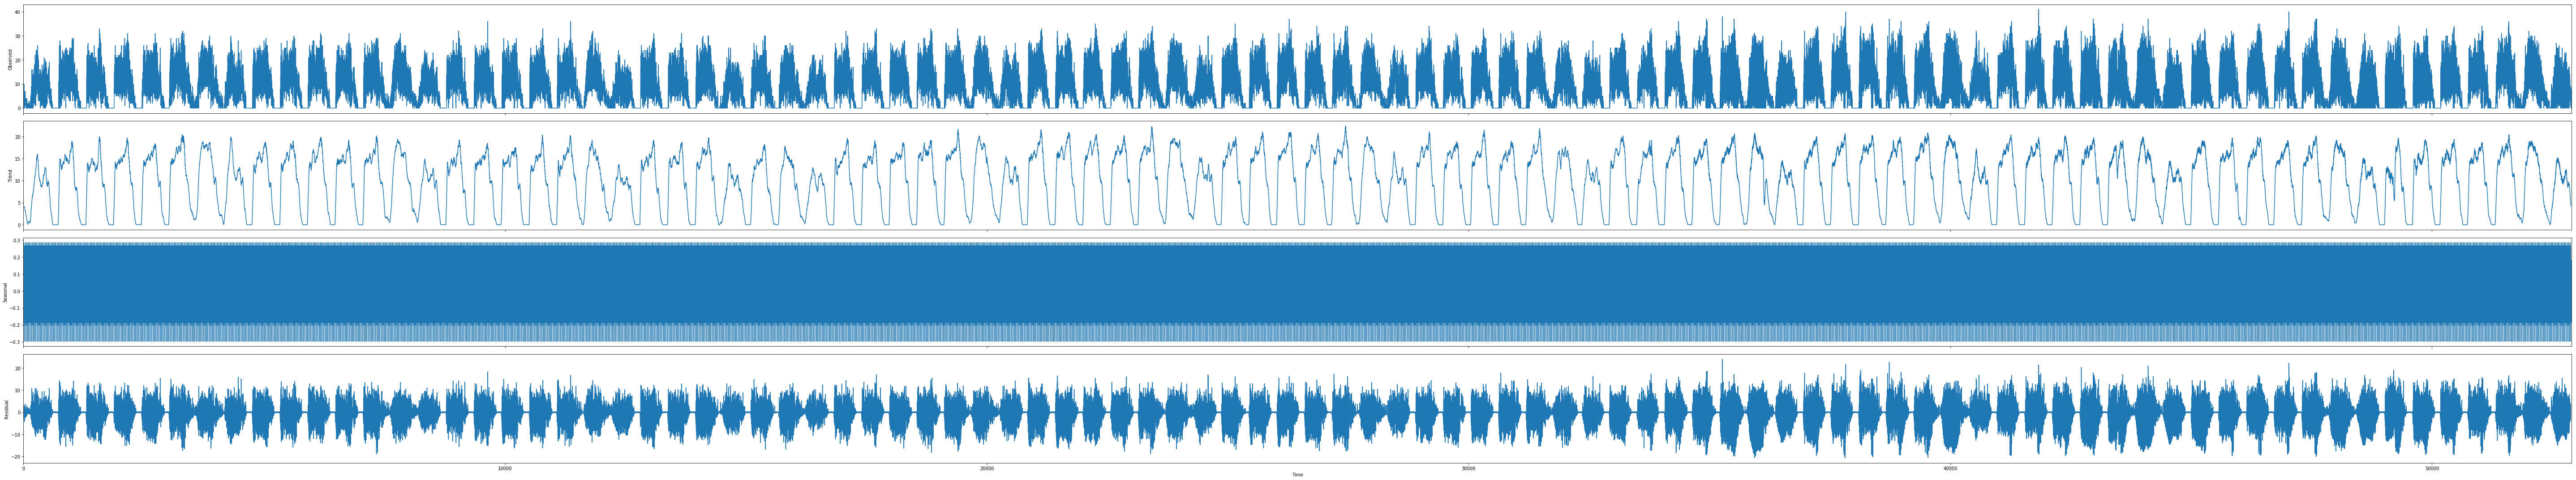

In [104]:
# TODO: why 30?
decomposition = sm.tsa.seasonal.seasonal_decompose(raw_seq, model='additive', freq=30)
fig = decomposition.plot()

plt.rcParams["figure.figsize"] = (80,15)
plt.plot()

# Prepare Dataset

This phase will form the input (X) and the output (Y)

In [0]:
def split_sequence(sequence):
  """ Split a univariate sequence into samples
  
  This function will split a sequence into many samples in the form of two
  arrays. The first array will have as elements arrays of size n_step and the 
  second array will have as elements a integer. 
  Example:
  
  split_sequence([1, 2, 3, 4, 5], 3) #=> ([[1, 2, 3], [2, 3, 4]], [4, 5])
  """
  
  n = len(sequence)
  X, Y = list(), list()
  
  for i in range(n):
    # find the end of this pattern
    end_ix = i + N_STEPS

    # check if we are beyond the sequence
    if end_ix + N_FUTURE > n-1:
      break

    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + N_FUTURE]
    X.append(seq_x)
    Y.append(seq_y[0] if MULTIVARIATE else seq_y)

  return np.array(X), np.array(Y)


def reshape_flow (raw_seq):  
  # split into samples
  X, Y = split_sequence(raw_seq)

  # reshape from [samples, timesteps] into [samples, timesteps, features]
  X = X.reshape((X.shape[0], X.shape[1], N_FEATURES))
  
  return X, Y


X, Y = reshape_flow(raw_seq)

# Baseline: Random

This implementation just guess a random number in the [0, 100] interval for every output.

In [106]:
def base_rand (Y):
  Y_hat = [rnd.randint(0, 100) for i in range(len(Y))]
    
  print_metrics(Y_hat, Y)
  
  
base_rand(Y)

RMSE: 50.24084555830687
MSE: 2524.142562413643
MAE: 41.80712812068215
Max Error: 100


# Baseline: Default

This implementation just get the mean of every flow value in the input and place it as output.

In [107]:
def base_default (X, Y):
  Y_hat = [st.mean([v[0] for v in x]) for x in X]
    
  print_metrics(Y_hat, Y)
  
  
base_default(X, Y)

RMSE: 6.739281906686772
MSE: 45.417920617795694
MAE: 4.984668672988473
Max Error: 34


# Baseline: ARIMA

This implementation was based on the article [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/).

## TODO

- Improve training speed
- Check if I need to improve
- Check stationarity
- Use Seasonal ARIMA
- Use grid search for optimal results

## Resources

+ [A Guide to Time Series Forecasting with ARIMA in Python 3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)
+ [Summary of rules for identifying ARIMA models](http://people.duke.edu/~rnau/arimrule.htm)


In [0]:
def base_arima (X):
  size = int(len(X) * TRAIN_SPLIT)
  acc = X[size-(2*WEEK_SIZE):size]
  Y = X[size+N_FUTURE:]
  Y_hat = []
  
  for t in range(len(Y)):
    print(t, len(Y))
    
    model = sm.tsa.arima_model.ARIMA(acc, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    
    start = len(acc)
    end = start + N_FUTURE
    
    prediction = model_fit.predict(start=start, end=end+1)
    
    Y_hat.append(prediction[-1])    
    acc.append(X[size + t])
    acc.pop(0)

  res = rmse(Y_hat, Y)
  print(f"RMSE: {res}")
  

#if MULTIVARIATE:
  #base_arima([e[0] for e in raw_seq])
#else:
  #base_arima(raw_seq)

# GRU

In [109]:
def gru (X, Y): 
  res = 0.0
  n_weeks = len(X) // WEEK_SIZE
  
  # define model
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(keras.layers.Dense(1))
  
  # compile model
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])

  for k in range(n_weeks - 4):
    # Get training of 3 weeks
    i = WEEK_SIZE * (k)
    j = WEEK_SIZE * (k + 3)
    X_train = X[i:j]
    Y_train = Y[i:j]
    
    # Get test of 1 week
    i = WEEK_SIZE * (k + 3)
    j = WEEK_SIZE * (k + 4)
    X_test = X[i:j]
    Y_test = Y[i:j]
    
    # Fit the model
    hist = model.fit(X_train, Y_train, validation_split=VALIDATION_SPLIT, batch_size=64, epochs=15, verbose=0) # verbose = 2
    
    # Predict for all x
    Y_hat = model.predict(X_test, verbose=2) # verbose = 2
        
    # Accumulate the RMSE
    res += np.sqrt(sklm.mean_squared_error(Y_test, Y_hat))

    #plot_history(hist, "gru")
    #print_metrics(Y_hat.round().flatten().tolist(), Y_test.tolist())

  print(f"K-validated RMSE: {res / (n_weeks - 4) }")


gru(X, Y)

K-validated RMSE: 5.265593097036093


# LSTM

In [110]:
def lstm (X, Y): 
  res = 0.0
  n_weeks = len(X) // WEEK_SIZE
  
  # define model
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(keras.layers.Dense(1))
  
  # compile model
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])

  for k in range(n_weeks - 4):
    # Get training of 3 weeks
    i = WEEK_SIZE * (k)
    j = WEEK_SIZE * (k + 3)
    X_train = X[i:j]
    Y_train = Y[i:j]
    
    # Get test of 1 week
    i = WEEK_SIZE * (k + 3)
    j = WEEK_SIZE * (k + 4)
    X_test = X[i:j]
    Y_test = Y[i:j]
    
    # Fit the model
    hist = model.fit(X_train, Y_train, validation_split=VALIDATION_SPLIT, batch_size=64, epochs=15, verbose=0) # verbose = 2
    
    # Predict for all x
    Y_hat = model.predict(X_test, verbose=2) # verbose = 2
        
    # Accumulate the RMSE
    res += np.sqrt(sklm.mean_squared_error(Y_test, Y_hat))
    
    #plot_history(hist, "lstm")
    #print_metrics(Y_hat.round().flatten().tolist(), Y_test.tolist())

  print(f"K-validated RMSE: {res / (n_weeks - 4) }")


lstm(X, Y)

K-validated RMSE: 5.537236200063437


# RNN

In [111]:
def rnn (X, Y): 
  res = 0.0
  n_weeks = len(X) // WEEK_SIZE
  
  # define model
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(50, activation='relu', input_shape=(N_STEPS, N_FEATURES)))
  model.add(keras.layers.Dense(1))
  
  # compile model
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])

  for k in range(n_weeks - 4):
    # Get training of 3 weeks
    i = WEEK_SIZE * (k)
    j = WEEK_SIZE * (k + 3)
    X_train = X[i:j]
    Y_train = Y[i:j]
    
    # Get test of 1 week
    i = WEEK_SIZE * (k + 3)
    j = WEEK_SIZE * (k + 4)
    X_test = X[i:j]
    Y_test = Y[i:j]
    
    # Fit the model
    hist = model.fit(X_train, Y_train, validation_split=VALIDATION_SPLIT, batch_size=64, epochs=15, verbose=0) # verbose = 2
    
    # Predict for all x
    Y_hat = model.predict(X_test, verbose=2) # verbose = 2
        
    # Accumulate the RMSE
    res += np.sqrt(sklm.mean_squared_error(Y_test, Y_hat))
    
    #plot_history(hist, "rnn")
    #print_metrics(Y_hat.round().flatten().tolist(), Y_test.tolist())

  print(f"K-validated RMSE: {res / (n_weeks - 4) }")


rnn(X, Y)

K-validated RMSE: 5.224392172853946


# Observations:

+ For the evaluation of the RNN and it's variations was used the Walking Forward methodology so that we had many test sessions and all training sessions where the same size [[1]](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9)